#Mount GDrive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/'My Drive'/'Colab Notebooks'/
# cd /content/drive/My Drive/Sop_GPS_Classification/PreProcessedData_Final/

/content/drive/My Drive/Colab Notebooks


In [0]:
ls

#Import the required libraries

In [0]:
!pip install pyproj

In [0]:
import numpy as np
import pandas as pd
# import sklearn as sk
# from sklearn.decomposition import PCA
# from geopy.distance import geodesic
# import mpu
import pyproj
# import warnings
# warnings.filterwarnings('ignore')
# except:
#     pass
# import keras
# # from keras.activation import adam
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Input
# from keras.utils import to_categorical
import glob

from datetime import datetime
from datetime import timedelta
from IPython.display import clear_output


#Preprocessing

Extracting all the required file names.

In [0]:
path = '20190818'
all_files = glob.glob(path+ "/*.csv")
print(all_files)
clear_output()

Reading all the files as dataframes and appending them to a list.

In [0]:
li=[]
i=0
for filename in all_files :
    df = pd.read_csv(filename, index_col=None, header= None, sep=';')
    if (i%1000 == 0):
      print(i)
    i = i + 1
    li.append(df)
clear_output()

Removing redundant columns.

In [0]:
for i in range(len(li)):
    if(i!=0):
      df=li[i]
      df.drop(['d1', 'd2', 'd3'], axis=1, inplace=True)
      # df.rename(columns={4:'d1', 6:'d1', 7:'d2', 8:'d3'}, inplace=True)
      if i%1000 == 0:
        print(i)
      i=i+1
clear_output()

Creating a dictionary for storing all the information of one vehicle in one dataframe.

In [0]:
uniqueID=dict()
for i in range(len(li)):
  for j in range(li[i].shape[0]):
    if(uniqueID.get(li[i].at[j,'id']) == None):
      uniqueID[li[i].at[j,'id']] = 1
    else:
      uniqueID[li[i].at[j,'id']] += 1
  if i%1000 == 0:
    print(i)

clear_output()

Creating the necessary columns.

In [0]:
dictOfList={}
for ID in uniqueID:
    dictOfList[ID] = [] #create a dictionary of lists
for j in range(len(li)):
  for k in range(li[j].shape[0]):
    tmpDict = {}
    tmpDict.update({'id':li[j].at[k,'id']})
    tmpDict.update({'time':li[j].at[k,'time']})
    tmpDict.update({'lat':li[j].at[k,'lat']})
    tmpDict.update({'long':li[j].at[k,'long']})
    tmpDict.update({'speed':li[j].at[k,'speed']})
    # tmpDict.update({'class':li[j].at[k,'class']})
    dictOfList[li[j].at[k,'id']].append(tmpDict)   
  if(j%1000 == 0):
    print(j)  
clear_output() 

Storing all the information about a vehicle in one single dataframe in the dictionary of dataframes.

In [0]:
preData=[]
for key in dictOfList:
  frame=pd.DataFrame(dictOfList[key])
  preData.append(frame)

Saving this  processed data in csv format on disk.

In [0]:
for i in range(len(preData)):
  name = './TestPreProcessedData_1/DataFile_'+str(i+1)+'.csv'
  preData[i].to_csv(name)

Reading the vehicle-wise data from disk.

In [0]:
path = 'TestPreProcessedData_1'
all_files = glob.glob(path+ "/*.csv")
vehicles=[]
i = 0
for fileName in all_files:
  frame = pd.read_csv(fileName, sep = ',')
  vehicles.append(frame)
  if i%1000 == 0:
    print(i)
  i += 1

clear_output()

Adding the necessary columns for learning the model.

In [0]:
# Adding new columns for speed,datetime,etc
for i in range(len(vehicles)):
    vehicles[i].insert(loc=6, column='dist', value=1.0)
    vehicles[i].insert(loc=7, column='LatLongSpeed', value=1.0)
    vehicles[i].insert(loc=8, column='acc', value=1.0)
    vehicles[i].insert(loc=9, column='datetime',value=datetime.strptime('1857/08/15 00:00:00', '%Y/%m/%d %H:%M:%S'))
    if(i%1000==0):
      print(i)
clear_output()

Parsing the timestamps into the datetime format.

In [0]:
#populating datetime and sorting according to time
for j in range(len(vehicles)):
    for k in range(0, vehicles[j].shape[0]):
        vehicles[j].at[k,'datetime'] = datetime.strptime(vehicles[j].at[k,'time'], '%Y/%m/%d %H:%M:%S')
    vehicles[j].sort_values(by='datetime',inplace=True,na_position='first')
    if(j%1000 == 0):
      print(j)
clear_output()

Dropping rows with duplicate values of timestamps.

In [0]:
for i in range(len(vehicles)):
  vehicles[i].drop_duplicates(subset=['datetime'], keep='first', inplace=True)

In [0]:
#Just to check whether duplicates remain or not
for i in range(len(vehicles)):
  if(any(vehicles[i]['datetime'].duplicated()) == True):
    print("Duplicate Exists in "+str(i))

Creating a new list of dataframes (one for each vehicle) for further preprocessing.

In [0]:
vehicles_new=[]
for i in range(len(vehicles)):
    reset_index_df = vehicles[i].reset_index(drop=True)
    vehicles_new.append(reset_index_df[['id', 'datetime','lat','long','dist','speed','LatLongSpeed','acc']].copy())

Checking for duplicate timestamps and empty vehicle data.

In [0]:
#In case, if duplicates remain, delete them forcefully
for i in range(len(vehicles_new)):
    duplicateRowsDF = vehicles_new[i][vehicles_new[i].duplicated(subset = ['datetime'],keep = 'first')]
    print("Duplicate Rows of :"+ str(i))
    index_duplicates=list(duplicateRowsDF.index.values)
    vehicles_new[i].drop(vehicles_new[i].index[index_duplicates],inplace = True)
clear_output()

In [0]:
#Check if some dataframe is empty or not
for i in range(len(vehicles_new)):
  if(vehicles_new[i].empty):
    print("I am Empty")
clear_output()

Saving this data back to disk for security.

In [0]:
for i in range(len(vehicles_new)):
  name = './TestPreProcessedData_2/DataFile_'+str(i+1)+'.csv'
  vehicles_new[i].to_csv(name)

Reading back the vehicular data.

In [0]:
vehicles_new=[]
path = 'TestPreProcessedData_2'
all_files = glob.glob(path+ "/*.csv")
i = 0
for fileName in all_files:
  frame = pd.read_csv(fileName, sep = ',')
  vehicles_new.append(frame)
  if i%1000 == 0:
    print(i)
  i += 1

clear_output()

0
1000
2000
3000


Extracting speed and acceleration at verious timestamps using GPS coordinates.

In [0]:
for j in range(len(vehicles_new)):
    # if(not vehicles_new[j].empty):
    vehicles_new[j].at[0,'dist']=0
    vehicles_new[j].at[0,'LatLongSpeed']=0
    vehicles_new[j].at[0,'acc']=0
    for k in range(1, vehicles_new[j].shape[0]):
        geod = pyproj.Geod(ellps='WGS84')
        lat0=vehicles_new[j].at[k-1,'lat']
        lon0=vehicles_new[j].at[k-1,'long']
        lat1=vehicles_new[j].at[k,'lat']
        lon1=vehicles_new[j].at[k,'long']

        a1, a2, dist = geod.inv(lon0, lat0, lon1, lat1)
        vehicles_new[j].at[k,'dist']=dist
        
        timediff = (vehicles_new[j].at[k,'datetime']-vehicles_new[j].at[k-1,'datetime']).total_seconds()/3600
        
        
        vehicles_new[j].at[k,'LatLongSpeed']=(vehicles_new[j].at[k,'dist']-vehicles_new[j].at[k-1,'dist'])/timediff
        
        vehicles_new[j].at[k,'acc']=(vehicles_new[j].at[k,'speed']-vehicles_new[j].at[k-1,'speed'])/timediff
    
    if(j%1000 == 0):
      print(j)
clear_output()

Checking for rows with data that cannot be processed further.

In [0]:
# To check if nan, inf or -inf exist in some entry of some row of some dataframe
for i in range(len(vehicles)):
    if(vehicles_new[i].isin([np.nan, np.inf, -np.inf]).any(1).values.any()):
        print(str(i)+" Exist")
    else:
        print(str(i)+" Not Exist")
clear_output()

For each vehicle, calculating aggregated parameters of speed and acceleration.

In [0]:
df2=pd.DataFrame(columns=['id','speed1_avg','speed2_avg','speed1_var','speed2_var','acc_avg','acc_var','class'])
for i in range(len(vehicles_new)):
    if(not vehicles_new[j].empty):
        df2.at[i,'speed1_avg'] = vehicles_new[i]['speed'].mean()
        df2.at[i,'speed2_avg'] = vehicles_new[i]['LatLongSpeed'].mean()
        df2.at[i,'speed1_var'] = vehicles_new[i]['speed'].var()
        df2.at[i,'speed2_var'] = vehicles_new[i]['LatLongSpeed'].var()
        df2.at[i,'acc_avg'] = vehicles_new[i]['acc'].mean()
        df2.at[i,'acc_var'] = vehicles_new[i]['acc'].var()
        df2.at[i,'id']= i
        df2.at[i,'class']= vehicles_new[i]['class'][0]
    if(i%100 == 0):
      print(i)
clear_output()

Finally, saving the preprocessed data.

In [0]:
df2.to_csv('./TestPreProcessedData_Final/FinalData.csv')

#Analysis and Training


In [0]:
!ls
%cd drive/

Reading the vehicular data from disk.

In [0]:
df2 = pd.read_csv('FinalData.csv')
df2['class'].unique()
# df2['class'].nunique()

Importing the required libraries.

In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import sys
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold

Dropping the columns which are useless, and replacing NA values with mean.

In [0]:
df4 = df2
df4 = df4[df4['class'] != 'Not available']
y = df4['class']
df4=df4.drop(columns = ['id','class'])
df4.drop(df4.columns[df4.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
# 'speed1_avg','speed2_avg','speed1_var','speed2_var','acc_avg','acc_var'
df4 = df4.fillna(df4.mean())

print(df4.shape)

Scaling the data.

In [0]:
names = df4.columns
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df4)
scaled_df = pd.DataFrame(scaled_df, columns=names)
df4=scaled_df

Plotting the data for analysis.

In [0]:
df4.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

In [0]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df4.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.9)
t= f.suptitle('Vehicle Attributes Correlation Heatmap', fontsize=14)

In [0]:
fig = plt.figure(figsize=(8, 6))
t = fig.suptitle('speed1_avg - speed2_avg - speed1_var - speed2_var - acc_avg - acc_var', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = list(df4['speed1_avg'])
ys = list(df4['speed2_avg'])
zs = list(df4['speed1_var'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]

# ss = list(df4['speed2_var'])
colors = ['red' if wt <= 1000 else 'yellow' for wt in list(df4['acc_avg'])]
# markers = [',' if q == 'high' else 'x' if q == 'medium' else 'o' for q in list(df4['acc_var'])]

# ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')
for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z, c=color, edgecolors='none')
    # print(data)

ax.set_xlabel('speed1_avg')
ax.set_ylabel('speed2_avg')
ax.set_zlabel('speed1_var')

Principal Component Analysis

In [0]:
for i in range(1,7): 
  pca = PCA(n_components = i)
  pca.fit(df4)
  print(sum(pca.explained_variance_ratio_))

# Shallow Models

K-Fold Cross-Validation with k=5.

In [0]:
cv = KFold(n_splits=5, random_state=2, shuffle=True)
avg_accuracy=0.0
string = ""
for train_index, test_index in cv.split(df4):
  X_tr, X_tst, y_tr, y_tst = df4.iloc[train_index], df4.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
  clf=BaggingClassifier(n_estimators=100)
  model = clf.fit(X_tr, y_tr)
  predicted= model.predict(X_tst)
  string = string + str(round((metrics.accuracy_score(y_tst, predicted)*100),2)) + ' & '
  avg_accuracy = avg_accuracy + metrics.accuracy_score(y_tst, predicted)

string = string + (str(round((avg_accuracy/5)*100,2)))
print(string)

92.93 & 90.17 & 91.23 & 91.08 & 92.31 & 91.54


Splitting the data into train and test sets.

In [0]:
X_tr, X_tst, y_tr, y_tst = train_test_split(df4, y, test_size=0.3)
# X_tr, X_tst, y_tr, y_tst = train_test_split(df4, y_one_hot, test_size=0.2)

Training Shallow Models.

In [0]:
#KNN Model
clf=KNeighborsClassifier()
clf.fit(X_tr, y_tr)
predicted= clf.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))
print(KNeighborsClassifier())

In [0]:
#Naive Bayes Model
clf=BernoulliNB()
clf.fit(X_tr, y_tr)
predicted= clf.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))

In [0]:

#SVC Model
clf=SVC()
clf.fit(X_tr, y_tr)
predicted= clf.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))

In [0]:
#Random Forest Model
clf=RandomForestClassifier(n_estimators=1000,min_samples_leaf=3)
clf.fit(X_tr, y_tr)
predicted= clf.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))
# print(RandomForestClassifier())

0.9617834394904459


Parameter Tuning for Random Forest Classifier.

In [0]:
# #Tuning Parameters
# rfc = RandomForestClassifier()
# parameters = {
#     "n_estimators":[5,10,50,100],
#     "max_depth":[2,4,8,16,32,64,None],
#     "min_samples_leaf":[1,5,10,50]
# }
# cv = GridSearchCV(rfc,parameters,cv=5)
# cv.fit(X_tr,y_tr.values.ravel())
# print(f'Best parameters are: {cv.best_params_}')
# # print("\n")
# mean_score = cv.cv_results_['mean_test_score']
# std_score = cv.cv_results_['std_test_score']
# params = cv.cv_results_['params']
# for mean,std,params in zip(mean_score,std_score,params):
#   print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [0]:
#Decision Tree Model 
clf=DecisionTreeClassifier(min_samples_leaf=3, max_depth=4)
clf.fit(X_tr, y_tr)
predicted= clf.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))

In [0]:
#Ada Boost Model
clf=AdaBoostClassifier(n_estimators=100,learning_rate=1)
model = clf.fit(X_tr, y_tr)
predicted= model.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))
print(AdaBoostClassifier())

In [0]:
#Gradient Boost Model
clf=GradientBoostingClassifier()
model = clf.fit(X_tr, y_tr,)
predicted= model.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))
print(GradientBoostingClassifier())

In [0]:
#SGD Model
clf=SGDClassifier()
model = clf.fit(X_tr, y_tr)
predicted= model.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))
print(SGDClassifier())

In [0]:
#Bagging Model
clf=BaggingClassifier(n_estimators=100)
model = clf.fit(X_tr, y_tr)
predicted= model.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))
print(BaggingClassifier())

Parameter Tuning for XGB Model.

In [0]:

# for learning_rate in [0.1] :
for learning_rate in [0.01,0.03,0.05,0.1,0.3,0.5,1,3] :
  clf=XGBClassifier(booster='gbtree',objective='multi:softmax',num_class =10,eval_metric = 'merror', 
                     learning_rate=learning_rate,n_estimators=120,
                      max_depth=5, min_child_weigth = 3,gamma=0,subsample=0.7, colsample_bytree = 0.9,scale_pos_weight = 1,seed = 27)
    
  model = clf.fit(X_tr, y_tr)
  predicted= model.predict(X_tst)
  print('learning rate: '+ str(learning_rate) +"    Accuracy: " + str(metrics.accuracy_score(y_tst, predicted)))


In [0]:
#XGB Model
clf=XGBClassifier(booster='gbtree',objective='multi:softmax',num_class =10,eval_metric = 'merror', 
                     learning_rate=0.5,n_estimators=120,
                      max_depth=5, min_child_weigth = 3,gamma=0,subsample=0.7, colsample_bytree = 0.9,scale_pos_weight = 1,seed = 27)
model = clf.fit(X_tr, y_tr)
predicted= model.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))

Parameter Tuning for XGB Model using Grid Search Algorithm.

In [0]:
param_test1 = {
 'max_depth':range(1,10,1),
 'min_child_weight':range(1,10,1)
}
params = {
        'gamma':[i/10.0 for i in range(0,5)],
        'subsample':[i/10.0 for i in range(6,10)],
        'colsample_bytree':[i/10.0 for i in range(6,10)]
        }

gsearch1 = GridSearchCV(estimator = clf,param_grid = params,iid=False, cv=5)
gsearch1.fit(X_tr,y_tr)
gsearch1.best_params_, gsearch1.best_score_

Printing the best parameters.

In [0]:
gsearch1.best_params_, gsearch1.best_score_

Data Structures for Paramter Tuning of XGB Classifier.

In [0]:
# # Tuning parameters
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
# }


Printing the results of the Models.

In [0]:
report = classification_report(y_tst, predicted)
print(report)
matrix = confusion_matrix(y_tst, predicted)
print(matrix)

In [0]:
#To evaluate the model's predictions
report = classification_report(y_tst, predicted)
print(report)
matrix = confusion_matrix(y_tst, predicted)
print(matrix)

In [0]:
# Final Accuracy : 93% (Random Forest Classifier)
# F1 Score : 93%

# Neural network

Importing the required libraries.

In [0]:
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM

from sklearn import preprocessing
import sys

In [0]:
#Changing pandas dataframe to numpy array
X = df4.values
y = y.values

In [0]:
# # #Standarize OR Normalize the data here
# # #standardized_X = preprocessing.scale(X)

# names = df4.columns
# # Create the Scaler object
# scaler = preprocessing.StandardScaler()
# # Fit your data on the scaler object
# scaled_df = scaler.fit_transform(df4)
# scaled_df = pd.DataFrame(scaled_df, columns=names)
# X = scaled_df.iloc[:,1:7].values

# # # np.set_printoptions(threshold=sys.maxsize)



# # # integer encode
# # label_encoder = preprocessing.LabelEncoder()
# # integer_encoded = label_encoder.fit_transform(y)
# # print(integer_encoded)
# # # binary encode
# # onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
# # integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# # onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# # print(onehot_encoded)
# # # invert first example
# # inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
# # print(inverted)



# # #Label Encoder
# # # le = preprocessing.LabelEncoder()
# # # le.fit(y)
# # # y=le.transform(y)

One - hot encoding

In [0]:
# #Standarize OR Normalize the data here
# #standardized_X = preprocessing.scale(X)

# Onehotcenode
onehotencoder = preprocessing.OneHotEncoder(categories = 'auto' )
y_one_hot = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()

Splitting the data into test and train sets.
Initializing the model.

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y_one_hot,test_size = 0.41)

# define the keras model
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(15, activation='relu'))
# model.add(Dense(12, activation='relu'))
model.add(Dense(10, activation='softmax'))


Compiling the keras model and training it.

In [0]:
#Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit Keras Model.
history = model.fit(X_train, y_train, epochs=6000, batch_size=64)

# Make Predictions
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Printing the accuracy.

In [0]:
print('Accuracy is:', a*100)

Plotting the results.

In [0]:
import matplotlib.pyplot as plt

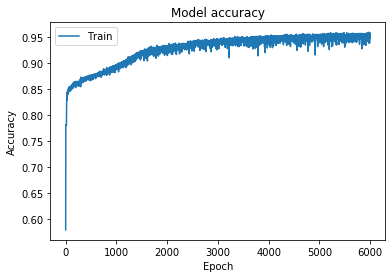

In [0]:
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


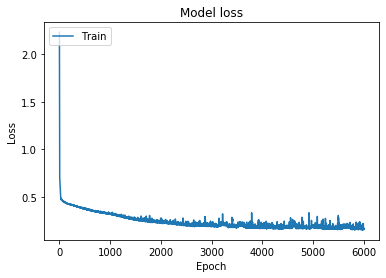

In [0]:

plt.plot(history.history['loss'])
# plt.plot(historyhistory['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [0]:
report = classification_report(y_tst, predicted)
print(report)
matrix = confusion_matrix(y_tst, predicted)
print(matrix)

Printing the results of the model.

In [0]:
print(y_pred)

In [0]:
print(pred)